In [34]:
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt

import pandas as pd
import numpy as np
from pandas.plotting import scatter_matrix

#from adtk.data import validate_series
#from adtk.visualization import plot
#from adtk.detector import ThresholdAD
#from adtk.detector import OutlierDetector

from sklearn.neighbors import LocalOutlierFactor

from scipy.stats import variation

import seaborn as sns

import matplotlib.pyplot as plt

import statsmodels.api as sm
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.api import ExponentialSmoothing
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_pacf,plot_acf
from statsmodels.stats.outliers_influence import variance_inflation_factor


from itertools import compress, product
#from pmdarima import auto_arima

import warnings
warnings.filterwarnings("ignore") # specify to ignore warning messages

# функция графика сезонности
def sesonal(data, s):
    plt.figure(figsize=(19,8), dpi= 80)
    for i, y in enumerate(data.index.year.unique()):
        plt.plot(list(range(1,len(data[data.index.year==y])+1)), data[data.index.year==y][data.columns[0]].values, label=y)
    plt.title("Сезонность по периодам")
    plt.legend(loc="best")
    plt.show()
    
def metrics(real, forecast):
    
    if type(real)==pd.core.frame.DataFrame:
        real=real[real.columns[0]].values
    
    print("Тест на стационарность:")
    dftest = adfuller(real-forecast, autolag='AIC')
    print("\tT-статистика = {:.3f}".format(dftest[0]))
    print("\tP-значение = {:.3f}".format(dftest[1]))
    print("Критические значения :")
    for k, v in dftest[4].items():
        print("\t{}: {} - Данные{} стационарны с вероятностью {}% процентов".format(k, v, " не" if v<dftest[0] else "", 100-int(k[:-1])))
    
    forecast=np.array(forecast)
    print('MAD:', round(abs(real-forecast).mean(),4))
    print('MSE:', round(((real-forecast)**2).mean(),4))
    print('MAPE:', round((abs(real-forecast)/real).mean(),4))
    print('MPE:', round(((real-forecast)/real).mean(),4))
    print('Стандартная ошибка:', round(((real-forecast)**2).mean()**0.5,4)) 
    

def metrics_short(real, forecast):
    real=np.array(real[real.columns[0]].values)
    forecast=np.array(forecast)
    print('MAD:', round(abs(real-forecast).mean(),4))
    print('MSE:', round(((real-forecast)**2).mean(),4))
    print('MAPE:', round((abs(real-forecast)/real).mean(),4))
    print('MPE:', round(((real-forecast)/real).mean(),4))
    print('Стандартная ошибка:', round(((real-forecast)**2).mean()**0.5,4)) 
    
def h_map(data, level):
    corr = data.corr()
    plt.figure(figsize=(14, 14))
    sns.heatmap(corr[(corr >= level) | (corr <= -level)],
            cmap="RdBu_r", vmax=1.0, vmin=-1.0, linewidths=0.1,
            annot=True, annot_kws={"size": 8}, square=True)
    plt.show()
    
#небольшая функция для построения набора комбинаций переменных
def combinations(items):
    return list( set(compress(items,mask)) for mask in product(*[[0,1]]*len(items)) )

def get_factors(data, Y, columns):

    # колонки, которые показали свою значимость в процессе отбора критериев
    # переменная spisCol хранит варианты комбинаций все переменных
    spisCol=combinations(columns)

    print('Количество комбинаций ', len(spisCol))
    
    #добавим константу в набор данных, нужна для рассчета регрессии
    data=sm.add_constant(data)

    #сохраним в этом списке данные лучших моделей
    arr_res=[]

    #пробежимся циклом по всем вариантам комбинаций
    for c in spisCol:
        perem=list(c)
        flag=True
    
        if len(perem)==0: continue
        
        if not('const' in c):
            perem.append('const')
        
        # если больше одного клитерия, рассчитаем VIF    
        if len(perem)>1:
            vif = [variance_inflation_factor(data[perem].values, i) for i in range(data[perem].shape[1])]
        else:
            vif=[]
    
        #проверим список VIF, если хоть одна переменная больше 1000 (очень большое значение, на самом деле),
        #то в модели присутсвует мультиколлинераность
        for vv in vif:
            if vv>1000: 
                flag=False
        
        #посчитаем саму модель
        reg = sm.OLS(Y, data[perem])
        res=reg.fit()

        #отбросим нулевую гипотезу для всех регрессоров конкретной модели
        for val in res.tvalues:
            if val<2 and val>-2:
                flag=False
                break
        for val in res.pvalues:
            if val>0.05:
                flag=False
                break
        #если нулевую гипотезу отбросили и VIF в норме, сохраним результаты
        if flag:
            re=np.array(res.fittedvalues.copy())
            MSE=((np.array(Y)-re)**2).sum()/len(re)
            
            MAPE=(abs((np.array(Y)-re)/np.array(Y))).sum()/len(re)
        
            arr_res.append([round(MSE,4), res.rsquared, perem])

    #отсортируем и выведем результаты
    arr_res.sort()
    df_model=pd.DataFrame(arr_res, columns=['MSE', 'r2', 'Переменные'])
    print('Результаты перебора в порядке возрастания MSE:')
    print(df_model)
    return df_model

In [35]:
df=pd.read_excel("/kaggle/input/vouchersdata/VouchersData.xlsx", index_col='date')
df.head()

,vouchers
date,
2018-01-01,105013
2018-02-01,78263
2018-03-01,97441
2018-04-01,125827
2018-05-01,200937


In [36]:
df.tail()

,vouchers
date,
2022-08-01,382153
2022-09-01,159120
2022-10-01,103245
2022-11-01,88535
2022-12-01,56414


<Axes: xlabel='date', ylabel='vouchers'>

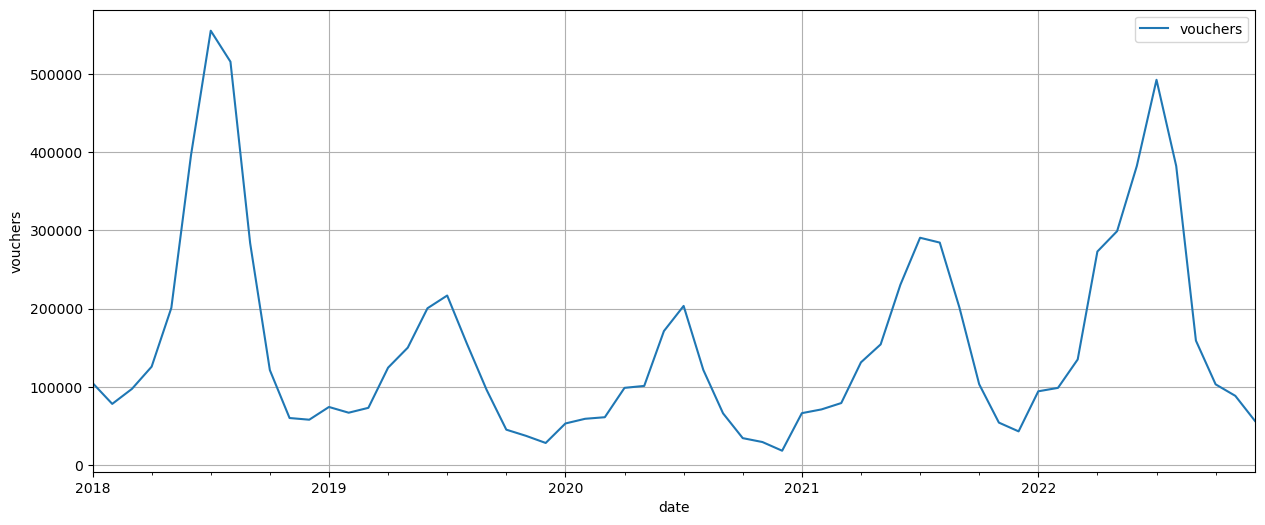

In [37]:
df.plot(figsize=(15, 6),ylabel='vouchers', grid=True)

In [38]:
df.describe()

,vouchers
count,60.000000
mean,152657.550000
std,125659.379318
min,18432.000000
25%,66383.500000
50%,103324.500000
75%,200985.750000
max,555045.000000


Text(0.5, 0.98, '')

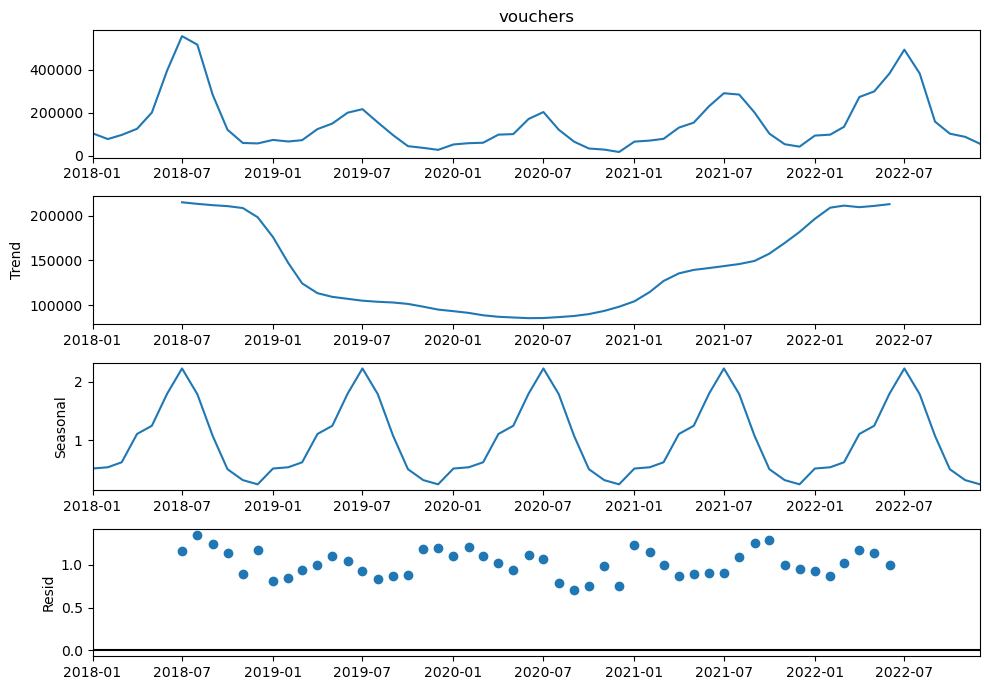

In [39]:
#Мультипликативная модель
result_M = seasonal_decompose(df.vouchers, model='multiplicative', period=12)

plt.rcParams.update({'figure.figsize': (10,7)})
result_M.plot().suptitle('')

Text(0.5, 0.98, '')

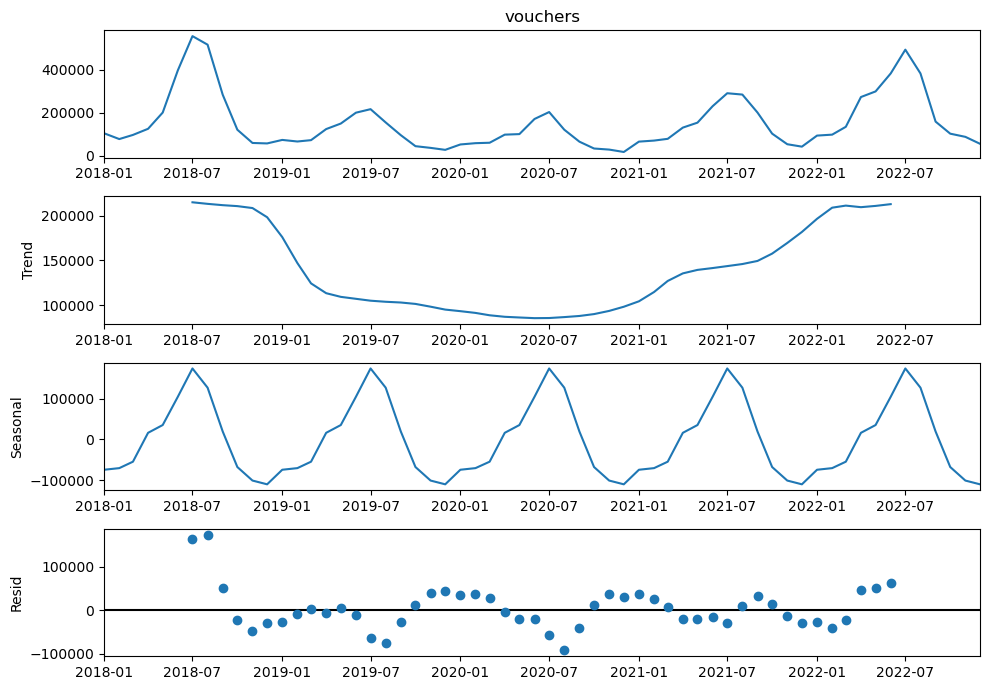

In [40]:
#Аддитивная модель
result_A = seasonal_decompose(df.vouchers, model='additive', period=12)

plt.rcParams.update({'figure.figsize': (10,7)})
result_A.plot().suptitle('')

In [41]:
train=df[:'2021']
train.tail()

,vouchers
date,
2021-08-01,284353
2021-09-01,201132
2021-10-01,103404
2021-11-01,54354
2021-12-01,43156


In [42]:
test=df['2022':]
test

,vouchers
date,
2022-01-01,94353
2022-02-01,98743
2022-03-01,135054
2022-04-01,272943
2022-05-01,298954
2022-06-01,382154
2022-07-01,492332
2022-08-01,382153
2022-09-01,159120


In [43]:
fit1 = ExponentialSmoothing(train, seasonal_periods=12, trend='add', seasonal='mul').fit()
fit1.params

{'smoothing_level': 0.8889285714285714,
 'smoothing_trend': 0.6584656084656084,
 'smoothing_seasonal': 0.06170634920634922,
 'damping_trend': nan,
 'initial_level': 247956.06666666656,
 'initial_trend': -12000.027272727264,
 'initial_seasons': array([0.54091025, 0.57261094, 0.63195802, 1.06316734, 1.21331705,
        1.82740281, 2.33023804, 1.76379641, 1.00438573, 0.46682053,
        0.32703017, 0.2583627 ]),
 'use_boxcox': False,
 'lamda': None,
 'remove_bias': False}

In [44]:
metrics(train, fit1.fittedvalues)

Тест на стационарность:
	T-статистика = -5.715
	P-значение = 0.000
Критические значения :
	1%: -3.6055648906249997 - Данные стационарны с вероятностью 99% процентов
	5%: -2.937069375 - Данные стационарны с вероятностью 95% процентов
	10%: -2.606985625 - Данные стационарны с вероятностью 90% процентов
MAD: 20032.0646
MSE: 747089784.2723
MAPE: 0.18
MPE: -0.0007
Стандартная ошибка: 27332.9432


In [45]:
fit2 = ExponentialSmoothing(train, seasonal_periods=12, trend='mul', seasonal='mul').fit()
metrics(train, fit2.fittedvalues)

Тест на стационарность:
	T-статистика = -6.589
	P-значение = 0.000
Критические значения :
	1%: -3.5778480370438146 - Данные стационарны с вероятностью 99% процентов
	5%: -2.925338105429433 - Данные стационарны с вероятностью 95% процентов
	10%: -2.6007735310095064 - Данные стационарны с вероятностью 90% процентов
MAD: 19408.0128
MSE: 713895481.1847
MAPE: 0.1695
MPE: -0.0345
Стандартная ошибка: 26718.8226


In [46]:
fit3 = ExponentialSmoothing(train, seasonal_periods=12, trend='add', seasonal='add').fit()
metrics(train, fit3.fittedvalues)

Тест на стационарность:
	T-статистика = -5.242
	P-значение = 0.000
Критические значения :
	1%: -3.5812576580093696 - Данные стационарны с вероятностью 99% процентов
	5%: -2.9267849124681518 - Данные стационарны с вероятностью 95% процентов
	10%: -2.6015409829867675 - Данные стационарны с вероятностью 90% процентов
MAD: 29401.3117
MSE: 1841423202.7057
MAPE: 0.2739
MPE: 0.088
Стандартная ошибка: 42911.8073


In [47]:
fit4 = ExponentialSmoothing(train, seasonal_periods=12, trend='mul', seasonal='add').fit()
metrics(train, fit4.fittedvalues)

Тест на стационарность:
	T-статистика = -5.206
	P-значение = 0.000
Критические значения :
	1%: -3.5812576580093696 - Данные стационарны с вероятностью 99% процентов
	5%: -2.9267849124681518 - Данные стационарны с вероятностью 95% процентов
	10%: -2.6015409829867675 - Данные стационарны с вероятностью 90% процентов
MAD: 28467.7323
MSE: 1703083971.9156
MAPE: 0.2545
MPE: 0.0704
Стандартная ошибка: 41268.438


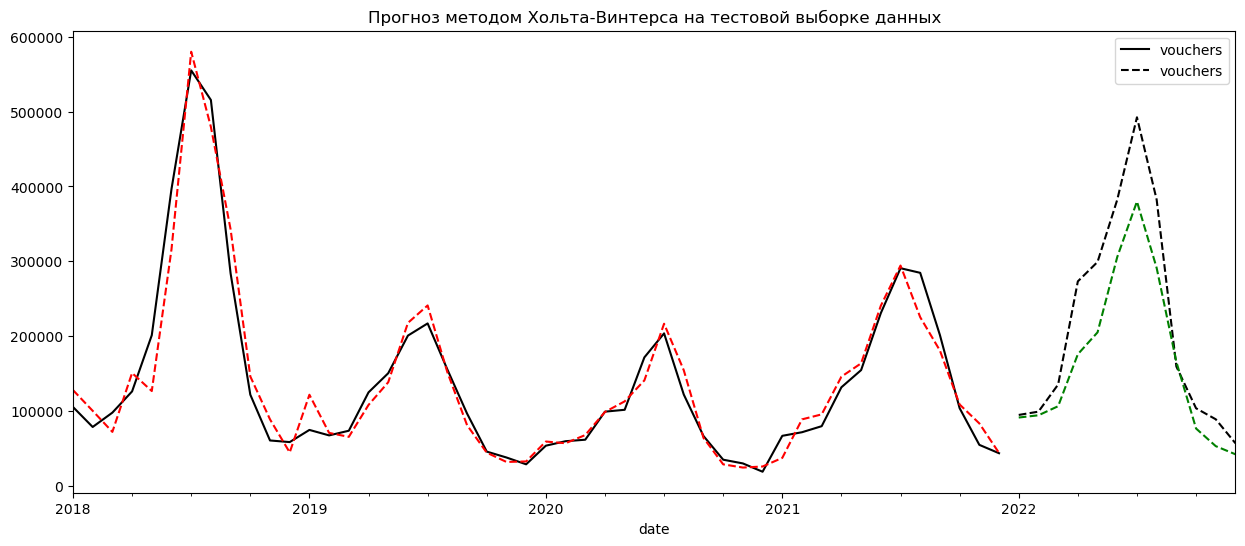

In [48]:
ax = train.plot(figsize=(15,6), color='black', title="Прогноз методом Хольта-Винтерса на тестовой выборке данных")
test.plot(ax=ax, style='--', color='black')
fit2.fittedvalues.plot(ax=ax, style='--', color='red')
fit2.forecast(12).plot(ax=ax, style='--', color='green')
plt.show()

In [49]:
train = train.append(test)
fit2 = ExponentialSmoothing(train, seasonal_periods=12, trend='mul', seasonal='mul').fit()
metrics(train, fit2.fittedvalues)

Тест на стационарность:
	T-статистика = -5.908
	P-значение = 0.000
Критические значения :
	1%: -3.548493559596539 - Данные стационарны с вероятностью 99% процентов
	5%: -2.912836594776334 - Данные стационарны с вероятностью 95% процентов
	10%: -2.594129155766944 - Данные стационарны с вероятностью 90% процентов
MAD: 20076.5623
MSE: 847274082.4818
MAPE: 0.1643
MPE: -0.0327
Стандартная ошибка: 29107.9728


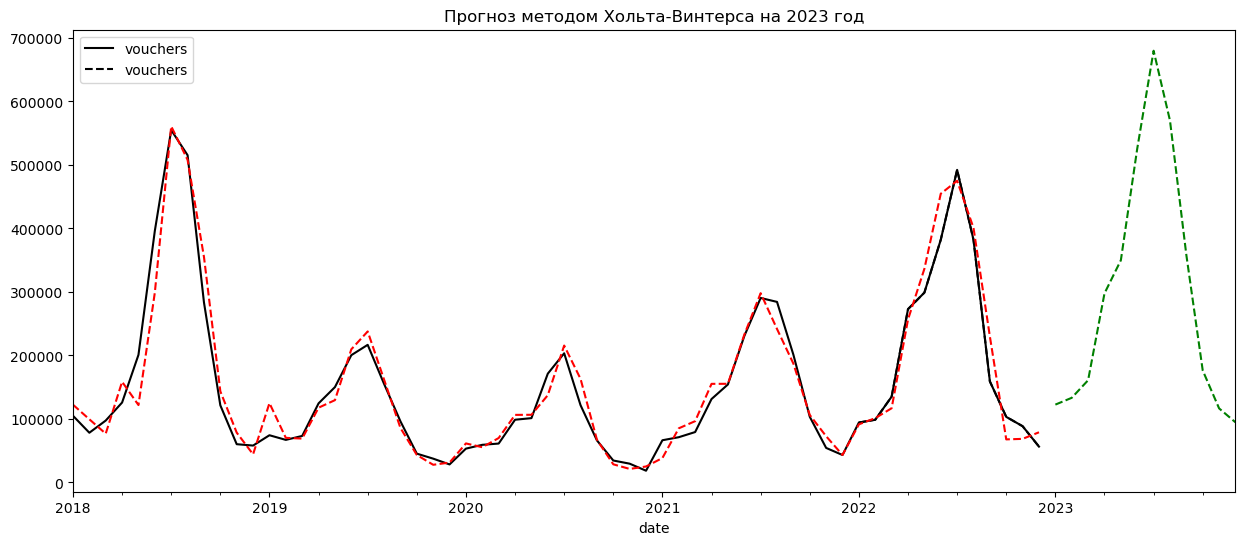

In [50]:
ax = train.plot(figsize=(15,6), color='black', title="Прогноз методом Хольта-Винтерса на 2023 год")
test.plot(ax=ax, style='--', color='black')
fit2.fittedvalues.plot(ax=ax, style='--', color='red')
fit2.forecast(12).plot(ax=ax, style='--', color='green')
plt.show()

In [51]:
fit2.forecast(12)

2023-01-01    122565.177160
2023-02-01    133272.187079
2023-03-01    160993.048823
2023-04-01    297724.689515
2023-05-01    349944.149833
2023-06-01    525758.491788
2023-07-01    679973.079836
2023-08-01    570017.381333
2023-09-01    358219.276157
2023-10-01    176412.688121
2023-11-01    116610.554668
2023-12-01     94674.268753
Freq: MS, dtype: float64